In [1]:
import numpy as np
import pandas as pd 
import datetime
import pickle
import shap

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import matplotlib as mpl
import bisect
from IPython.display import display, Image

pd.set_option('display.max_columns', None)

# Create and save SHAP plots (all variables)

In [7]:
n = 100
path = '../results/shap/'

for nback in range(1,6):    
    for i, sex in enumerate(['men', 'women']):
        filename1 = 'Xshap' + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
        filename2 = 'shapvals'  + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
        
        X_test = pickle.load(open(path+filename1, 'rb'))
        shapvals = pickle.load(open(path+filename2, 'rb'))
        
        print(sex, nback)
        plt.figure(figsize=(8, 8))
        fig = shap.summary_plot(-1*shapvals, X_test, max_display=50, show=False)
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.title('SHAP values for SVM-'+str(nback)+', '+sex)
        plt.savefig('../results/plots_shap/shapvals_'+sex+'_'+str(nback)+'.png', bbox_inches='tight')
        plt.close()

men 1
women 1
men 2
women 2
men 3
women 3
men 4
women 4
men 5
women 5


# Create and save SHAP plots (only Hb variables)

In [8]:
n = 100
path = '../results/shap_onlyhb/'

for nback in range(1,6):    
    for i, sex in enumerate(['men', 'women']):
        filename1 = 'Xshap' + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
        filename2 = 'shapvals'  + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
        
        X_test = pickle.load(open(path+filename1, 'rb'))
        shapvals = pickle.load(open(path+filename2, 'rb'))
        
        print(sex, nback)
        plt.figure(figsize=(8, 8))
        fig = shap.summary_plot(-1*shapvals, X_test, max_display=50, show=False)
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.title('SHAP values for SVM-'+str(nback)+', '+sex)
        plt.savefig('../results/plots_shap/onlyhb_shapvals_'+sex+'_'+str(nback)+'.png', bbox_inches='tight')
        plt.close()

men 1
women 1
men 2
women 2
men 3
women 3
men 4
women 4
men 5
women 5


# Create and save SHAP plots (Hb + genetic variables)

In [9]:
n = 100
path = '../results/shap_hbgen/'

for nback in range(1,6):    
    for i, sex in enumerate(['men', 'women']):
        filename1 = 'Xshap' + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
        filename2 = 'shapvals'  + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
        
        X_test = pickle.load(open(path+filename1, 'rb'))
        shapvals = pickle.load(open(path+filename2, 'rb'))
        
        print(sex, nback)
        plt.figure(figsize=(8, 8))
        fig = shap.summary_plot(-1*shapvals, X_test, max_display=50, show=False)
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.title('SHAP values for SVM-'+str(nback)+', '+sex)
        plt.savefig('../results/plots_shap/hbgen_shapvals_'+sex+'_'+str(nback)+'.png', bbox_inches='tight')
        plt.close()

men 1
women 1
men 2
women 2
men 3
women 3
men 4
women 4
men 5
women 5


# All SHAP plots (all variables)

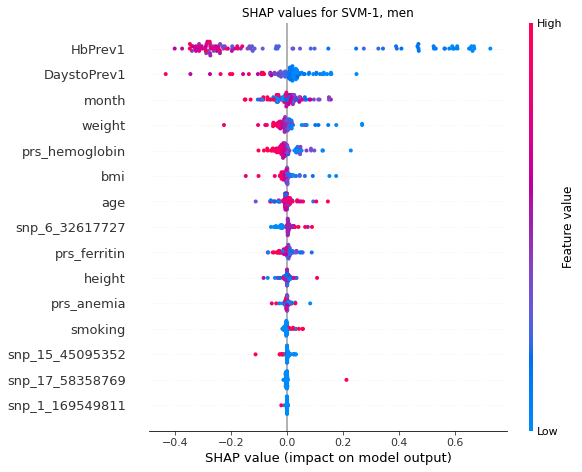

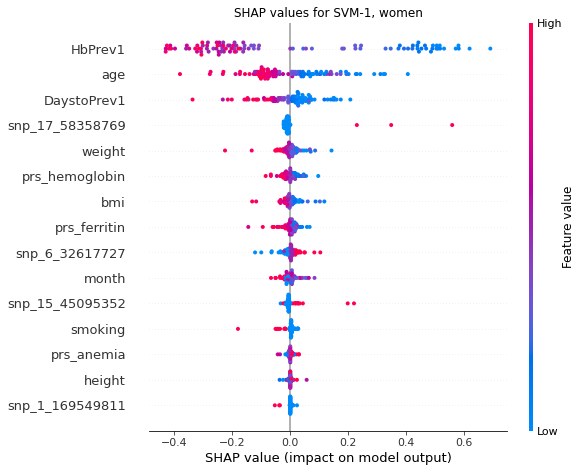

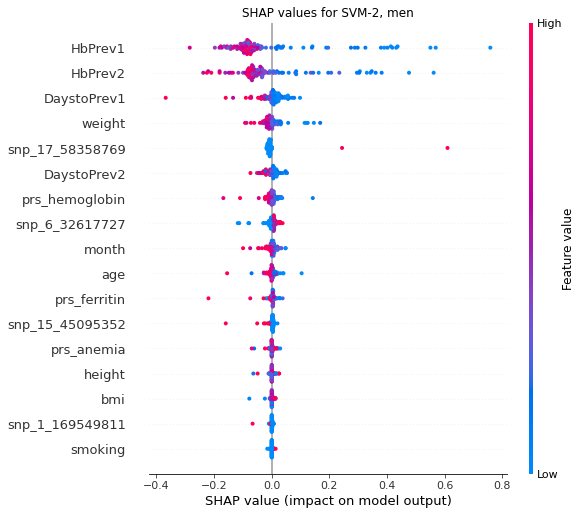

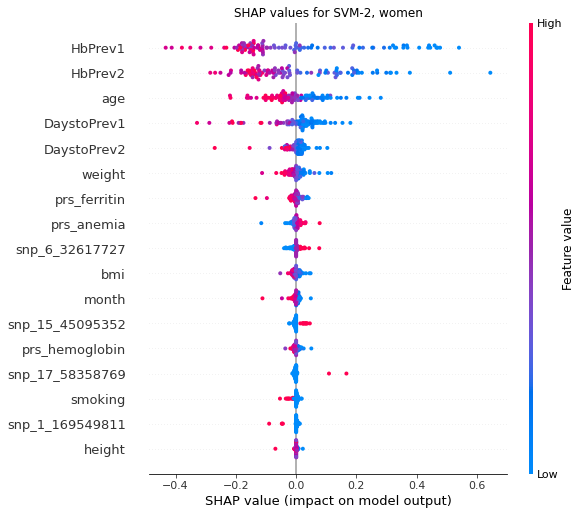

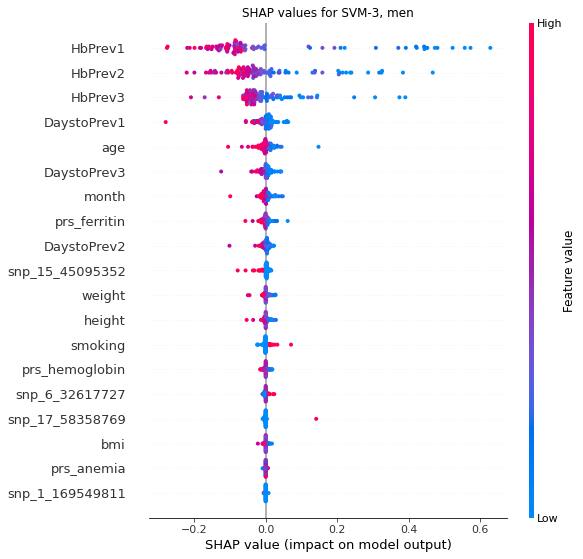

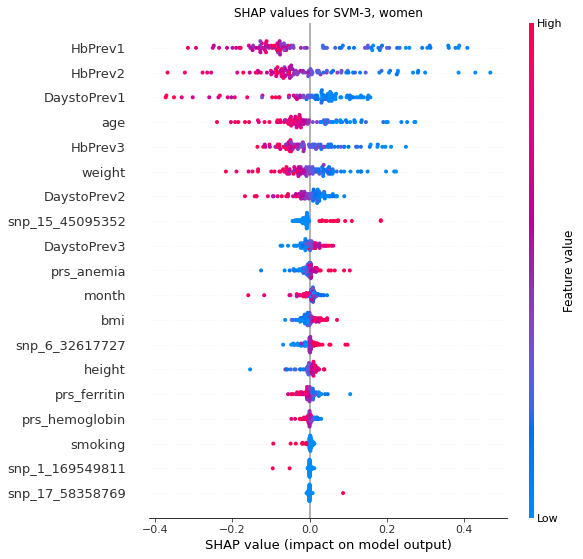

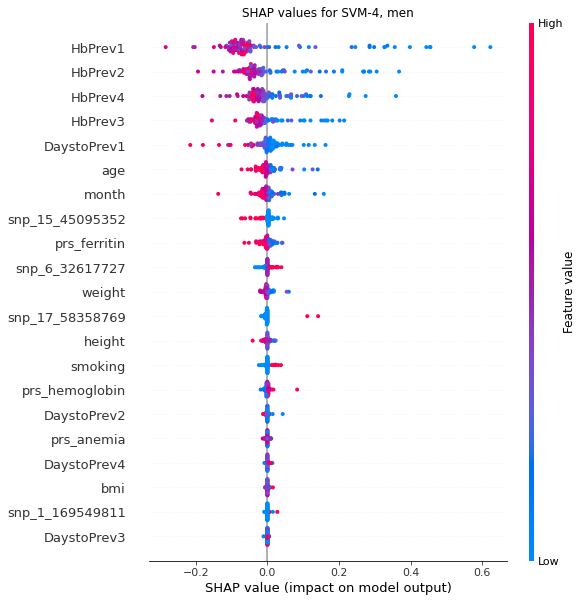

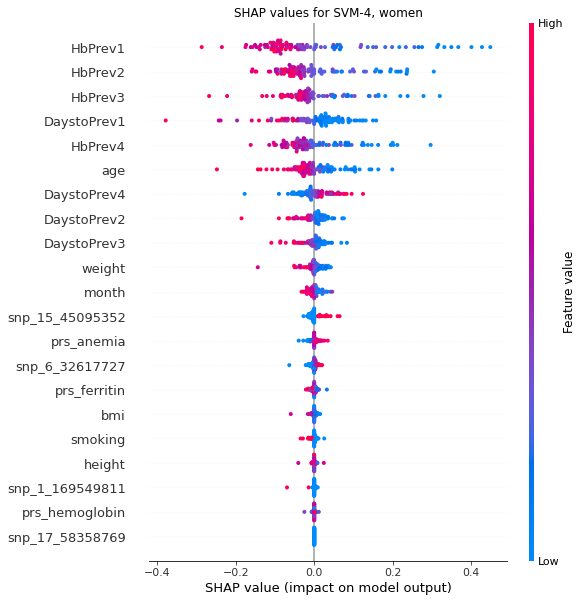

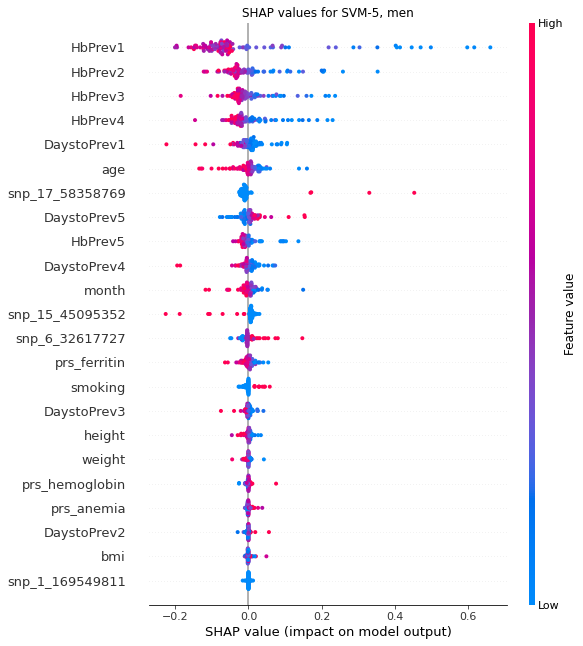

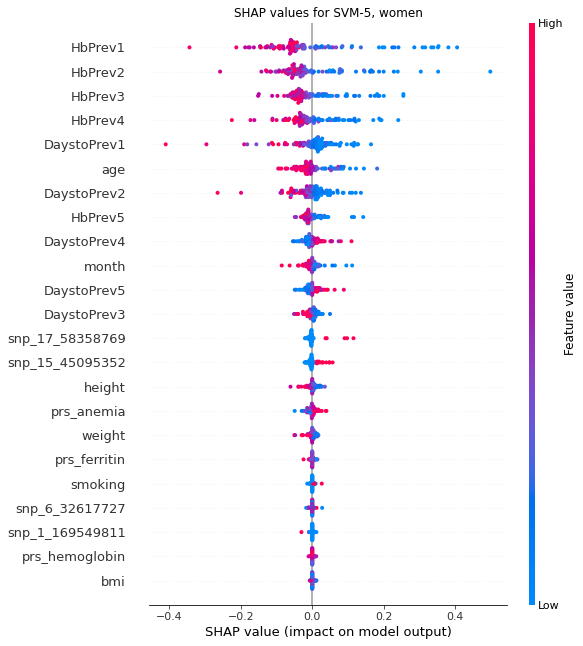

In [19]:
for nback in range(1,6):    
    for i, sex in enumerate(['men', 'women']):
        img = Image('../results/plots_shap/shapvals_'+sex+'_'+str(nback)+'.png')
        display(img)

# All SHAP plots (only Hb variables)

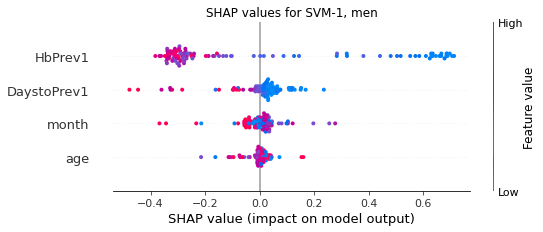

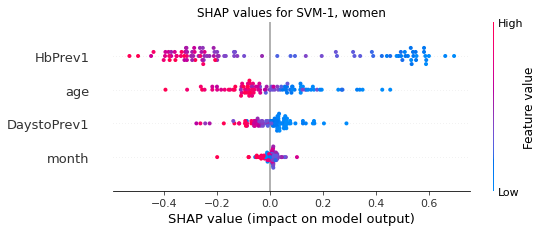

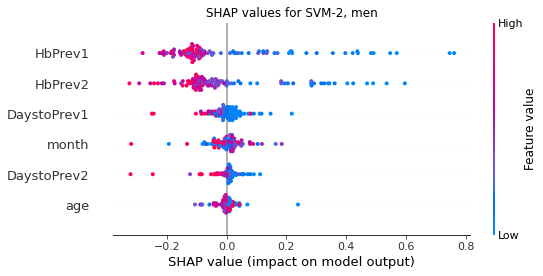

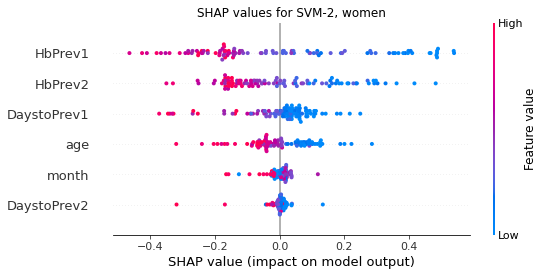

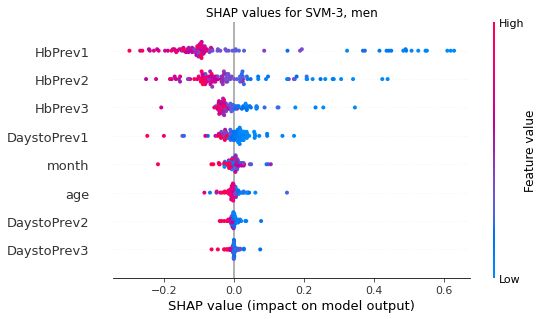

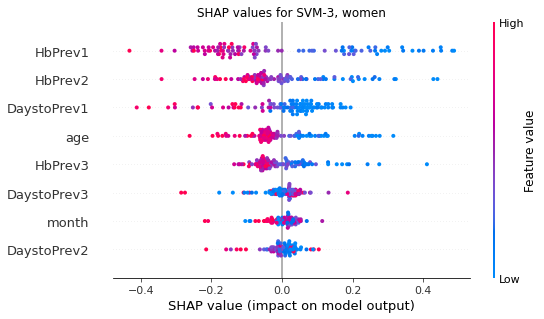

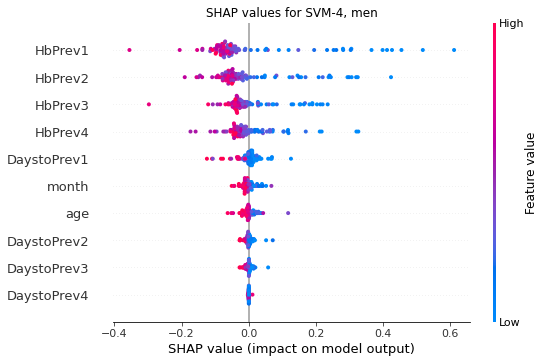

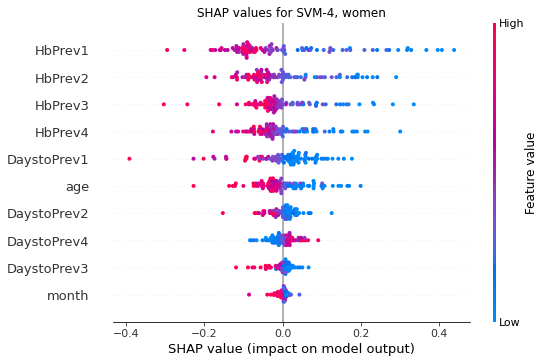

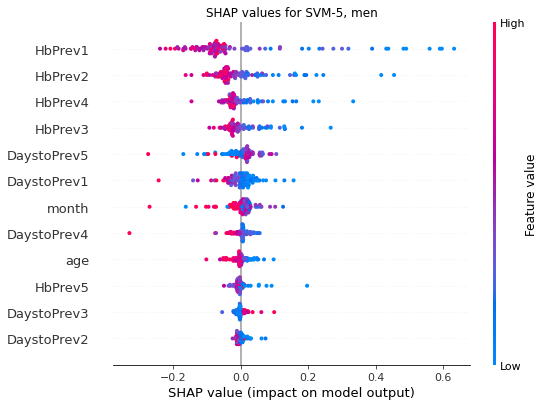

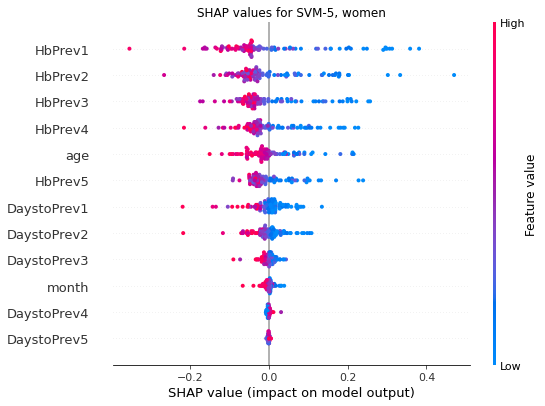

In [20]:
for nback in range(1,6):    
    for i, sex in enumerate(['men', 'women']):
        img = Image('../results/plots_shap/onlyhb_shapvals_'+sex+'_'+str(nback)+'.png')
        display(img)